In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
from scipy.optimize import curve_fit
from astropy import constants as const
import warnings
from scipy.stats import bootstrap
import scipy
from scipy import interpolate
import math
warnings.filterwarnings("ignore")
import matplotlib.colors as mcolors
from scipy.stats import skewnorm
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.cluster import KMeans


In [2]:
dataLI = pd.read_csv(r"C:\Users\silke\Desktop\Thesis\STPM_improved_210721.csv",delimiter=",")
dataEA = pd.read_csv(r"C:\Users\silke\Desktop\Thesis\Exoplanet_Archive.csv",delimiter=",")
planet_name_LI        = list(dataLI["Star"]+" "+dataLI["Planet"])
dataLI["planet_name"] = planet_name_LI

earth_like_rocky  = pd.read_csv(r"C:\Users\silke\Desktop\Thesis\Mass_Radius_Curves\Earth-like Rocky (32.5% Fe+67.5% MgSiO3).txt",delimiter = "\t")
pure_rock         = pd.read_csv(r"C:\Users\silke\Desktop\Thesis\Mass_Radius_Curves\pure-Rock (100% MgSiO3).txt",delimiter = "\t")
H20_50_300K       = pd.read_csv(r"C:\Users\silke\Desktop\Thesis\Mass_Radius_Curves\50% H2O (50% Earth-like rocky core + 50% H2O layer by mass)_300 K_1mili-bar surface temprture.txt",delimiter = "\t")
H20_50_500K       = pd.read_csv(r"C:\Users\silke\Desktop\Thesis\Mass_Radius_Curves\50% H2O (50% Earth-like rocky core + 50% H2O layer by mass)_500 K_1mili-bar surface temprture.txt",delimiter = "\t")
H20_50_700K       = pd.read_csv(r"C:\Users\silke\Desktop\Thesis\Mass_Radius_Curves\50% H2O (50% Earth-like rocky core + 50% H2O layer by mass)_700 K_1mili-bar surface temprture.txt",delimiter = "\t")

earth_Mass = const.M_earth.value*1000 #g
earth_Radius = const.R_earth.value*100
earth_Volume = 4/3 * math.pi * earth_Radius**3
earth_density = earth_Mass / earth_Volume

In [3]:
# Luque Impoved
planet_id_LI         = dataLI.ID
star_name_LI         = dataLI.Star
planet_letter_LI     = dataLI.Planet

radius_LI            = dataLI.R_Rterra            # [Earth Radius]
radius_unc_up_LI     = dataLI.euR_Rterra          # [Earth Radius] Upper Unc.
radius_unc_low_LI    = dataLI.edR_Rterra          # [Earth Radius] Lower Unc.

mass_LI              = dataLI.M_Mterra            # [Earth Mass] - Planet Mass or Mass*sin(i) [Earth Mass]
mass_unc_up_LI       = dataLI.euM_Mterra          # [Earth Mass] Upper Unc.
mass_unc_low_LI      = dataLI.edM_Mterra          # [Earth Mass] Lower Unc.

density_LI           = dataLI[dataLI.columns[32]]  # [g/cm**3]
density_unc_up_LI    = dataLI[dataLI.columns[33]]  # [g/cm**3] Planet Density Upper Unc. 
density_unc_low_LI   = dataLI[dataLI.columns[34]]  # [g/cm**3] Planet Density Lower Unc
star_eff_LI          = dataLI.Teff_K
pl_eq_LI             = dataLI.Teq_K                # [K] Equilibrium Temperature

# Exoplanet Archive
planet_name_EA       = dataEA.pl_name
planet_id_EA         = list(range(0,len(planet_name_EA)))

radius_EA            = dataEA.pl_rade            # [Earth Radius]
period_EA            = dataEA.pl_orbper          # [days]
radius_unc_up_EA     = dataEA.pl_radeerr1        # [Earth Radius] Upper Unc.
radius_unc_low_EA    = dataEA.pl_radeerr2        # [Earth Radius] Lower Unc.
mass_EA              = dataEA.pl_bmasse          # [Earth Mass] - Planet Mass or Mass*sin(i) [Earth Mass]

mass_unc_up_EA       = dataEA.pl_bmasseerr1      # [Earth Mass] Upper Unc.
mass_unc_low_EA      = dataEA.pl_bmasseerr2      # [Earth Mass] Lower Unc.

density_EA           = dataEA.pl_dens            # [g/cm**3]
density_unc_up_EA    = dataEA.pl_denserr1        # [g/cm**3] Planet Density Upper Unc. 
density_unc_low_EA   = dataEA.pl_denserr2        # [g/cm**3] Planet Density Lower Unc. 
st_spectype_EA       = dataEA.st_spectype        # Spectral type of star
pl_eq_EA             = dataEA.pl_eqt             # [K] Equilibrium Temperature
st_eff_EA            = dataEA.st_teff            # Star effective temprature
st_eff_up_EA         = dataEA.st_tefferr1        # Star upper err effective temprature
st_eff_low_EA        = dataEA.st_tefferr2        # Star lower err effective temprature
disc_year_EA         = dataEA.disc_year

In [4]:
planet2      = []; planet_i2       = []; planet_eq2   = []
disc_year2   = []; st_eff2         = []; spectype2    = []
radius2      = []; radius_up2      = []; radius_low2  = []
mass2        = []; mass_up2        = []; mass_low2    = []
density2     = []; density_up2     = []; density_low2 = []
other_names = ['LHS 1140 c' ,'L 168-9 b', 'L 168-9 c']

for i in range(0,len(planet_name_EA)):
    if ((radius_unc_up_EA[i] + radius_unc_up_EA[i])*0.5) / radius_EA[i] < 0.08 and radius_EA[i]<4:
        if radius_EA[i]<4:
            if "M" in str(st_spectype_EA[i]) or st_eff_EA[i] < 3500:
                if st_eff_EA[i] < 3997: 
                    if ((mass_unc_up_EA[i] + mass_unc_up_EA[i])*0.5) / mass_EA[i] < 0.25 and math.isnan(density_unc_low_EA[i]) == False:
                        if planet_name_EA[i] not in planet_name_LI and planet_name_EA[i] not in other_names:
                            st_eff2.append(st_eff_EA[i]); spectype2.append(st_spectype_EA[i])
                            planet_eq2.append(pl_eq_EA[i]); planet2.append(planet_name_EA[i]); disc_year2.append(disc_year_EA[i])
                            radius2.append(dataEA.pl_rade[i]); radius_up2.append(dataEA.pl_radeerr1[i]); radius_low2.append(dataEA.pl_radeerr2[i])
                            density2.append(dataEA.pl_dens[i]); density_up2.append(dataEA.pl_denserr1[i]); density_low2.append(dataEA.pl_denserr2[i])
                            mass2.append(dataEA.pl_bmasse[i]); mass_up2.append(dataEA.pl_bmasseerr1[i]);  mass_low2.append(dataEA.pl_bmasseerr2[i])


Text(0.5, 1.0, 'STPMs Luque Improved sample')

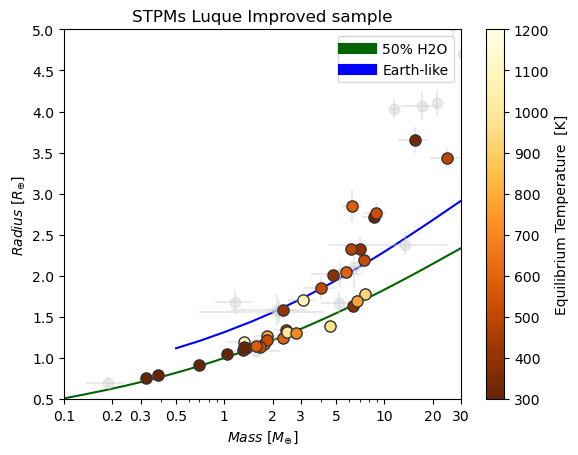

In [5]:
planets = ["K2-146 b",'TRAPPIST-1 h', 'TRAPPIST-1 d', 'TRAPPIST-1 e', 'TRAPPIST-1 f', 'TRAPPIST-1 g', 'TRAPPIST-1 c', 'TRAPPIST-1 b', 'GJ 1132 b', 'TOI-270 b', 'GJ 3053 c', 'GJ 1252 b', 'GJ 357 b', 'LTT 3780 b', 'LHS 1478 b', 'GJ 486 b', 'GJ 3473 b', 'CD-60 8051 b', 'L 98-59 c', 'L 98-59 d', 'GJ 3053 b', 'TOI-270 d', 'TOI-776 b', 'TOI-1634 b', 'TOI-1685 b', 'TOI-1235 b', 'K2-146 c', 'LTT 3780 c', 'TOI-270 c', 'K2-18 b', 'TOI-269 b', 'GJ 1214 b', 'K2-25 b', 'TOI-1231 b']
mass_err_LI   = [mass_unc_low_LI,mass_unc_up_LI]
radius_err_LI = [radius_unc_low_LI,radius_unc_up_LI]
plt.errorbar(mass_LI,radius_LI,xerr = mass_err_LI, yerr=radius_err_LI,fmt='.',markersize = 15,color = "0.8",zorder=-32,alpha = 0.4)

plt.plot(list(earth_like_rocky["Mass"]),list(earth_like_rocky["Radius"]),"-",color = "Darkgreen",label = "50% H2O",zorder = -40)
plt.plot(list(H20_50_500K["Mass"]),list(H20_50_500K["Radius"]),"-",color = "Blue",label = "Earth-like",zorder = -40)

norm = mcolors.Normalize(vmin=300, vmax=1200)  # Set the desired min and max values
cmap = plt.cm.get_cmap('YlOrBr_r')
for i in range(0,len(planet_name_LI)):
    if planet_name_LI[i] in planets:
        plt.scatter(mass_LI[i], radius_LI[i], c=[pl_eq_LI[i]], cmap=cmap, norm=norm, marker='o',s=65, edgecolors='0.2')   
cbar = plt.colorbar(label = "Equilibrium Temperature  [K]")
plt.xlabel("$Mass\ [M_{\oplus}]$")
plt.ylabel("$Radius\ [R_{\oplus}]$")
plt.xscale("log"); plt.xlim(0.1,30); plt.ylim(0.5,5)
plt.xticks([0.1,0.2,0.3,0.5,1,2,3,5,10,20, 30],["0.1","0.2","0.3","0.5","1","2","3","5","10","20", "30"],minor=False)
leg = plt.legend(loc = 1)
for line in leg.get_lines():
    line.set_linewidth(8.0)
plt.title("STPMs Luque Improved sample")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


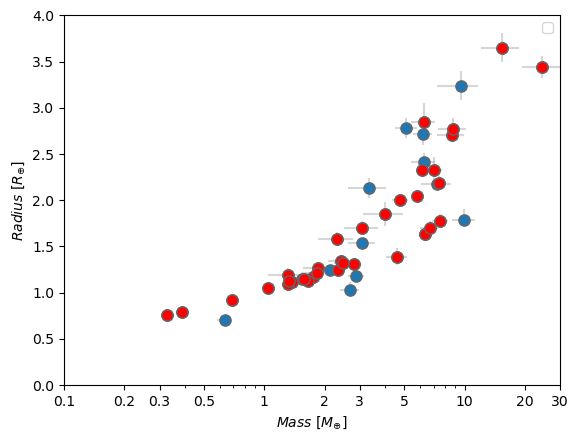

In [10]:
mass_LIV34 = []; radius_LIV34 = []; density_LIV34 = []
mass_LIV34_up    = []; mass_LIV34_low    = []; 
radius_LIV34_up  = []; radius_LIV34_low  = []; 
density_LIV34_up = []; density_LIV34_low = []; 

for i in range(0,len(planet_name_LI)):
    if planet_name_LI[i] in planets:
        mass_LIV34.append(mass_LI[i]); radius_LIV34.append(radius_LI[i]);density_LIV34.append(density_LI[i]);
        mass_LIV34_up.append(mass_unc_up_LI[i]);       mass_LIV34_low.append(mass_unc_low_LI[i])
        radius_LIV34_up.append(radius_unc_up_LI[i]);   radius_LIV34_low.append(radius_unc_low_LI[i])
        density_LIV34_up.append(density_unc_up_LI[i]); density_LIV34_low.append(density_unc_low_LI[i])

mass = np.concatenate((mass2,mass_LIV34))
density = np.concatenate((density2,density_LIV34))
radius = np.concatenate((radius2,radius_LIV34))
planet = np.concatenate((planet2,planets))

mass_up    = np.concatenate((mass_up2,mass_LIV34_up));          mass_low = np.concatenate((mass_low2,mass_LIV34_low))
radius_up  = np.concatenate((radius_up2,radius_LIV34_up));    radius_low = np.concatenate((radius_low2,radius_LIV34_low))
density_up = np.concatenate((density_up2,density_LIV34_up)); density_low = np.concatenate((density_low2,density_LIV34_low))

mass_error    = [np.abs(mass_low),mass_up]
radius_error  = [np.abs(radius_low),radius_up]
density_error = [np.abs(density_low),density_up]

plt.errorbar(mass,radius,xerr = mass_error, yerr=radius_error,fmt='.',markersize = 15,color = "0.6",zorder=-32,alpha = 0.4)
plt.scatter(mass,radius,marker='o',s=65, edgecolors='0.4')
plt.scatter(mass_LIV34,radius_LIV34,marker='o',s=65, edgecolors='0.4',color = "red")
for i in range(0,len(planet_name_LI)):
    if planet_name_LI[i] in planets:
        0 == 0 
        #plt.scatter(mass_LI[i], radius_LI[i], c="red", norm=norm, marker='o',s=65, edgecolors='0.2')   

plt.xlabel("$Mass\ [M_{\oplus}]$")
plt.ylabel("$Radius\ [R_{\oplus}]$")
plt.xscale("log"); 
plt.xlim(0.1,30),plt.ylim(0,4)
plt.xticks([0.1,0.2,0.3,0.5,1,2,3,5,10,20, 30],["0.1","0.2","0.3","0.5","1","2","3","5","10","20", "30"],minor=False)
leg = plt.legend(loc = 1)
for line in leg.get_lines():
    line.set_linewidth(8.0)
    
#mass_lim = []; radius_lim = []
#for i in range(0,len(mass)):
#    if 0 < mass[i] < 100 and 0 < radius[i] < 100:
#        mass_lim.append(mass[i]); radius_lim.append(radius[i]);
#plt.scatter(mass_lim,radius_lim)



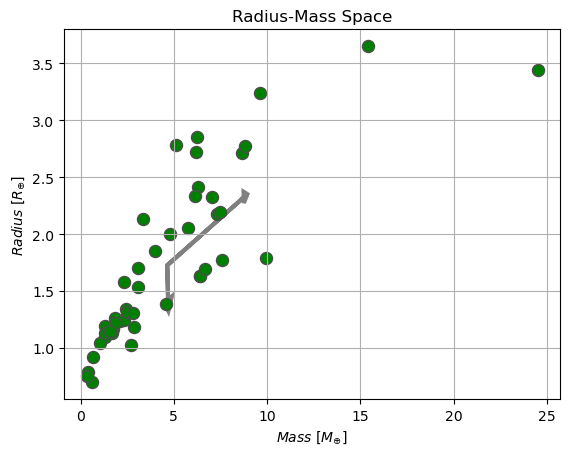

In [7]:
df = pd.DataFrame({'Mass': mass, 'Radius': radius})
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

data = np.column_stack((mass, radius)); mean_vector = np.mean(data, axis=0)
centered_data = np.column_stack(((mass-mean_vector[0]), (radius-mean_vector[1])  ))
covariance_matrix = np.cov(centered_data, rowvar=False); eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
k = 2
top_k_eigenvectors = eigenvectors[:, :k]
projected_data = np.dot(centered_data, top_k_eigenvectors)
data = np.column_stack((mass, radius)) - mean_vector
projected_data = np.dot(data, top_k_eigenvectors)
                        
PC1 = np.array([0.98958828, 0.1439272])
PC2 = np.array([0.1439272 , -0.98958828])
scaled_PC1 = np.sqrt(eigenvalues[0]) * PC1
scaled_PC2 = np.sqrt(eigenvalues[1]) * PC2 

plt.arrow(mean_vector[0], mean_vector[1],scaled_PC1[0],scaled_PC1[1] ,length_includes_head = True,lw = 3,head_width=0.1, head_length=0.2, fc='0.5', ec='0.5', label='Scaled PC2')
plt.arrow(mean_vector[0], mean_vector[1],scaled_PC2[0],scaled_PC2[1] ,length_includes_head = True,lw = 3, head_width=0.4, head_length=0.1, fc='0.5', ec='0.5', label='Scaled PC2')

plt.scatter(mass, radius,color = "green",s=75, edgecolor = "0.3")
plt.ylabel('$Radius \ [R_{\oplus}]$'); plt.xlabel("$Mass\ [M_{\oplus}]$")
plt.title('Radius-Mass Space')
plt.grid(zorder = -32)


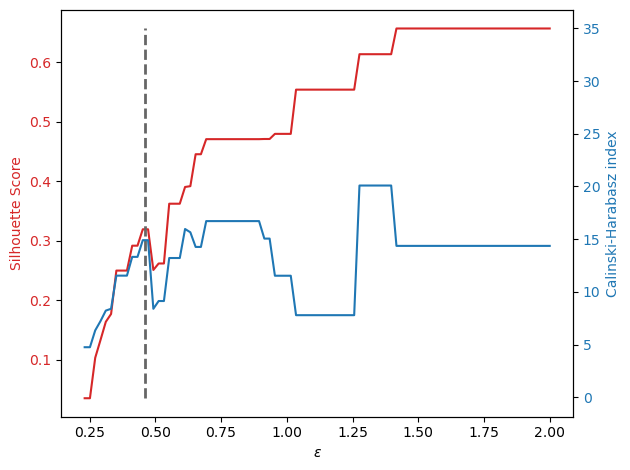

In [573]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel("$\epsilon$")
ax1.set_ylabel("Silhouette Score", color=color)
ax1.plot(epsilon,sscore, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Calinski-Harabasz index', color=color)  # we already handled the x-label with ax1
ax2.plot(epsilon,CH_score, color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.vlines(0.46,-0.1,35,colors = "0.4",linestyle = "dashed",zorder=-32,linewidth = 2)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

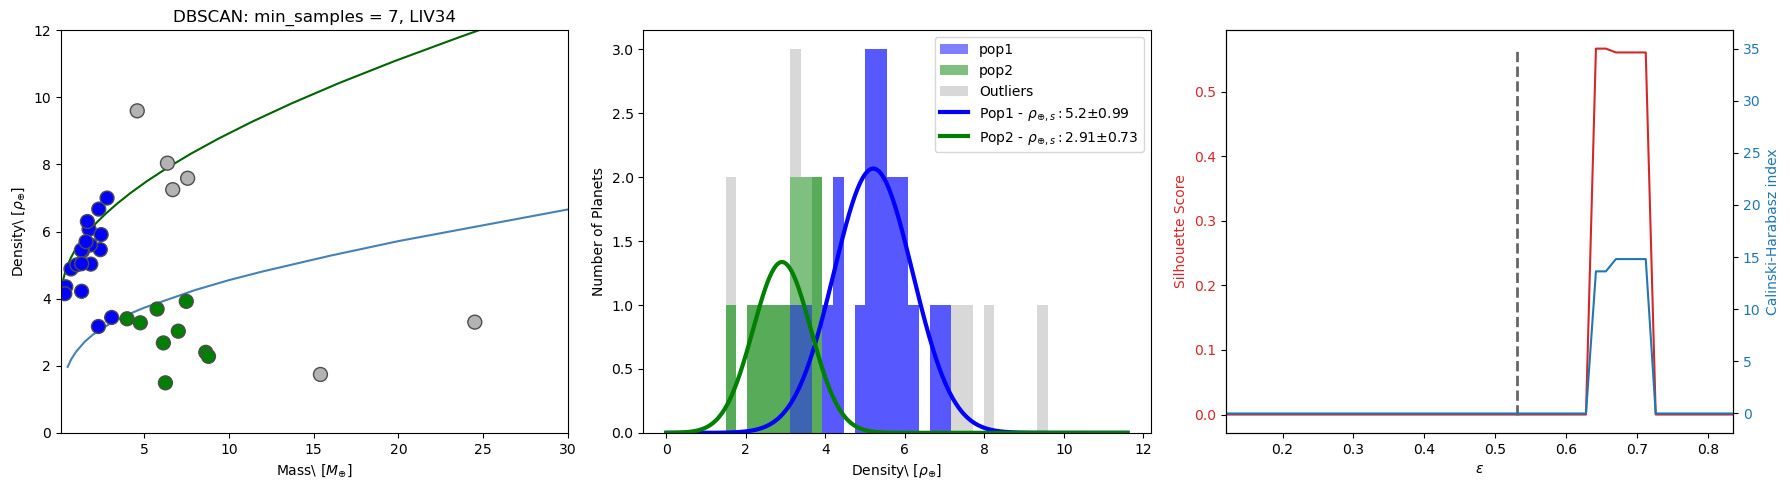

In [386]:
def colorlist(labels):
    color=["0.7",'blue', 'green']
    colors = []
    for i in range(len(labels)):
        if labels[i] == -1:
            colors.append(color[0])
        if labels[i] == 0:
            colors.append(color[1])
        if labels[i] == 1:
            colors.append(color[2])
        if labels[i] == 2:
            colors.append(color[3])
        if labels[i] == 3:
            colors.append(color[4])
        if labels[i] == 4:
            colors.append(color[5])
    return colors


fig, ax = plt.subplots(figsize=(18,5))

# Subplot 1

ax = plt.subplot(1, 3, 1)
df = pd.DataFrame({'Mass': mass_LIV34, 'Density': density_LIV34})
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)
dbscan = DBSCAN(eps=0.7, min_samples=8)
clusters = dbscan.fit_predict(pca_result)
colors = colorlist(clusters)
pop1 = [density_LIV34[i] for i in range(len(clusters)) if clusters[i] == 0]
pop2 = [density_LIV34[i] for i in range(len(clusters)) if clusters[i] == 1]
pop3 = [density_LIV34[i] for i in range(len(clusters)) if clusters[i] == -1]
ax.scatter(mass_LIV34, density_LIV34, c=colors, s=100, edgecolor="0.3")
ax.plot(H20_50_500K["Mass"], H20_50_500K_density_g_cm3, "-", color="steelblue", label="50% H2O", zorder=-32)
ax.plot(earth_like_rocky["Mass"], earth_like_rocky_density_g_cm3, "-", color="darkgreen", label="Earth-Like", zorder=-32)
ax.set_xlim(0.1, 30)
ax.set_ylim(0,12)
ax.set_title("DBSCAN: min_samples = 7, LIV34")
ax.set_xlabel("Mass\ $[M_{\oplus}]$")
ax.set_ylabel("Density\ $[ρ_{\oplus}]$")

# Subplot 2
pop1 = [density_LIV34[i] for i in range(len(clusters)) if clusters[i] == 0]
pop2 = [density_LIV34[i] for i in range(len(clusters)) if clusters[i] == 1]
pop3 = [density_LIV34[i] for i in range(len(clusters)) if clusters[i] == -1]
ax = plt.subplot(1, 3, 2)
bins = 30
range_min = min(min(pop1), min(pop2), min(pop3))
range_max = max(max(pop1), max(pop2), max(pop3))
hbins  = np.linspace(0, range_max + 2, 1000)
ax.hist([pop1, pop2, pop3], bins=bins, range=(range_min, range_max), alpha=0.5, label=['pop1', 'pop2', 'Outliers'], color=['blue', 'green', "0.7"], stacked=True)
hist_values_false, bin_edges, _ = ax.hist(pop1, bins=bins,range=(range_min, range_max), color='Blue', alpha=0.3, density=False)
area_under_bars = np.sum(hist_values_false * np.diff(bin_edges))
mu = np.average(pop1)
sigma = np.sqrt(np.cov(pop1, ddof=0))
best_fit_line = scipy.stats.norm.pdf(hbins, mu, sigma)*area_under_bars
ax.plot(hbins, best_fit_line,color = "Blue",linewidth=3,label ="Pop1 - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)))

hist_values_false, bin_edges, _ = ax.hist(pop2, bins=bins,range=(range_min, range_max), color='Green', alpha=0.3, density=False)
area_under_bars = np.sum(hist_values_false * np.diff(bin_edges))
mu = np.average(pop2)
sigma = np.sqrt(np.cov(pop2, ddof=0))
best_fit_line = scipy.stats.norm.pdf(hbins, mu, sigma)*area_under_bars
ax.plot(hbins, best_fit_line,color = "Green",linewidth=3,label ="Pop2 - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)))
plt.legend()
ax.set_xlabel("Density\ $[ρ_{\oplus}]$")
ax.set_ylabel("Number of Planets")
# Subplot 3
ax = plt.subplot(1, 3, 3)
ax1 = ax
ax2 = ax.twinx()

PC1 = pca_result[:, 0]
PC2 = pca_result[:, 1]
isss = np.linspace(0.01, 1.4, 100)
scores_sillutet = []
scores_CH = []
data = np.column_stack((PC1, PC2))

for i, eps in enumerate(isss):
    dbscan = DBSCAN(eps=eps, min_samples=8, metric="euclidean")
    dbscan.fit(data)
    clusters = dbscan.fit_predict(pca_result)
    dbscan_labels = dbscan.fit_predict(pca_result)
    unique_labels = np.unique(dbscan_labels)
    num_clusters = len(unique_labels[unique_labels != -1])
    if num_clusters < 2:
        scores_sillutet.append(0)
        scores_CH.append(0)
    else:
        silhouette_avg = silhouette_score(pca_result[dbscan_labels != -1], dbscan_labels[dbscan_labels != -1])
        scores_sillutet.append(silhouette_avg)
        calinski_harabasz_index = calinski_harabasz_score(pca_result, dbscan_labels)
        scores_CH.append(calinski_harabasz_index)

color = 'tab:red'
ax1.set_xlabel("$\epsilon$")
ax1.set_ylabel("Silhouette Score", color=color)
ax1.plot(isss, scores_sillutet, color=color)
ax1.tick_params(axis='y', labelcolor=color)

color = 'tab:blue'
ax2.set_ylabel('Calinski-Harabasz index', color=color)
ax2.plot(isss, scores_CH, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.vlines(0.53, -0.1, 35, colors="0.4", linestyle="dashed", zorder=-32, linewidth=2)
ax.set_xlim(0.12, 0.835)
fig.tight_layout()


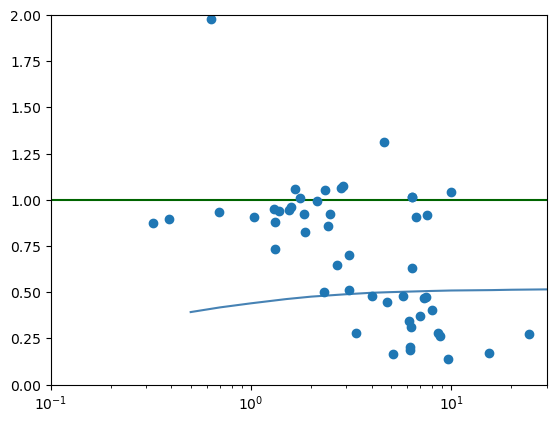

In [780]:
earth_like_rocky_mass_g        = earth_Mass*np.array(earth_like_rocky["Mass"])
earth_like_rocky_radius_cm     = earth_Radius*np.array(earth_like_rocky["Radius"])
earth_like_rocky_density_g_cm3 = (earth_like_rocky_mass_g) / ((4/3)*(np.pi)*(np.power(earth_like_rocky_radius_cm,3))   ) 

H20_50_500K_mass_g        = earth_Mass*np.array(H20_50_500K["Mass"])
H20_50_500K_radius_cm     = earth_Radius*np.array(H20_50_500K["Radius"])
H20_50_500K_density_g_cm3 = (H20_50_500K_mass_g) / ((4/3)*(np.pi)*(np.power(H20_50_500K_radius_cm,3))   ) 

def rocky_density(mass):
    x_points  = earth_like_rocky["Mass"]
    y_points  = earth_like_rocky_density_g_cm3
    tck       = interpolate.splrep(x_points, y_points)
    return interpolate.splev(mass, tck).tolist()

def rocky_density2(mass):
    x_points  = earth_like_rocky["Mass"]
    y_points  = earth_like_rocky_density_g_cm3/earth_like_rocky_density_g_cm3
    tck       = interpolate.splrep(x_points, y_points)
    return interpolate.splev(mass, tck).tolist()

def h20model_density(mass):
    x_points  = H20_50_500K["Mass"]
    y_points  = H20_50_500K_density_g_cm3/rocky_density(H20_50_500K["Mass"])
    tck       = interpolate.splrep(x_points, y_points)
    return interpolate.splev(mass, tck).tolist()

density_norm = density / rocky_density(mass)
plt.scatter(mass, density_norm)
plt.xlim(0.1, 30)
plt.ylim(0, 2); plt.xscale("log")
plt.plot(H20_50_500K["Mass"], H20_50_500K_density_g_cm3 / rocky_density(H20_50_500K["Mass"]), "-", color="steelblue", label="50% H2O", zorder=-32)
plt.plot(earth_like_rocky["Mass"], earth_like_rocky_density_g_cm3 / rocky_density(earth_like_rocky["Mass"]), "-", color="darkgreen", label="Earth-Like", zorder=-32)


(0.0, 12.0)

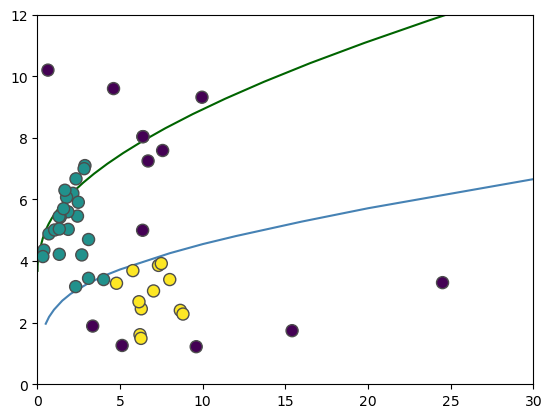

In [798]:
df = pd.DataFrame({'Mass': mass, 'Density': density})

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

dbscan = DBSCAN(eps=0.6, min_samples=8,metric = "euclidean")
dbscan.fit(scaled_data)
clusters = dbscan.fit_predict(pca_result)

plt.scatter(mass, density, c=clusters, s=75, edgecolor="0.3", cmap='viridis')
plt.plot(H20_50_500K["Mass"], H20_50_500K_density_g_cm3, "-", color="steelblue", label="50% H2O", zorder=-32)
plt.plot(earth_like_rocky["Mass"], earth_like_rocky_density_g_cm3, "-", color="darkgreen", label="Earth-Like", zorder=-32)
plt.xlim(0,30)
plt.ylim(0,12)

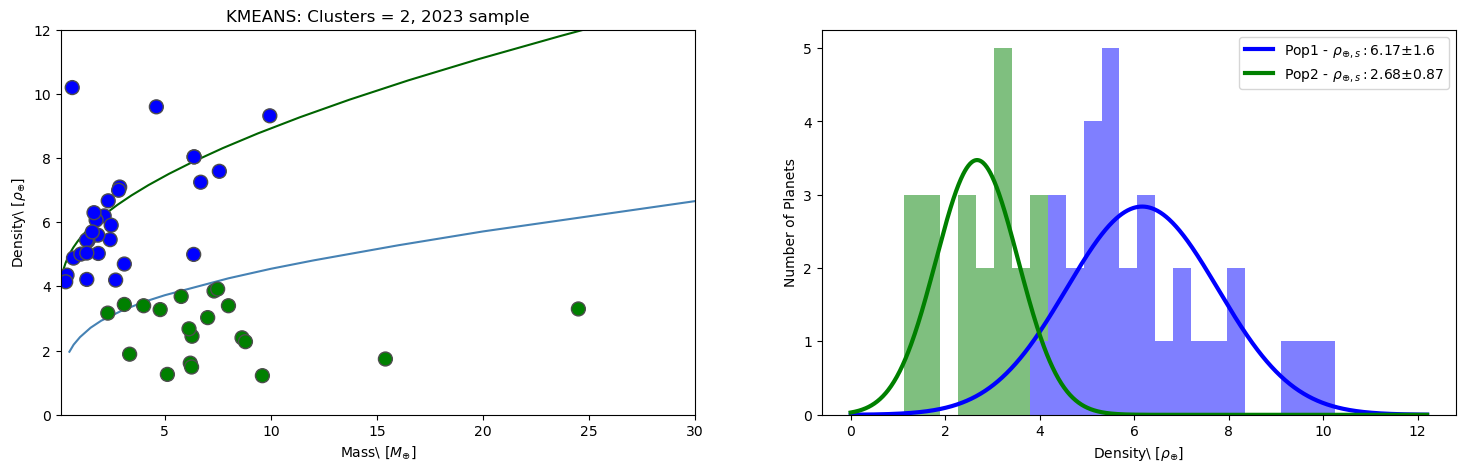

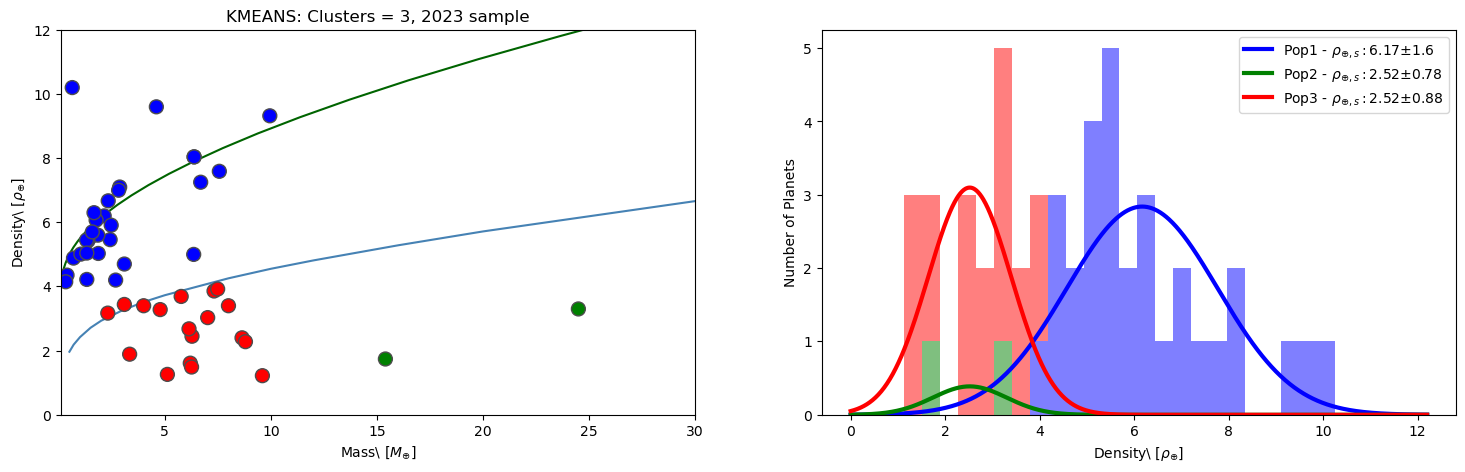

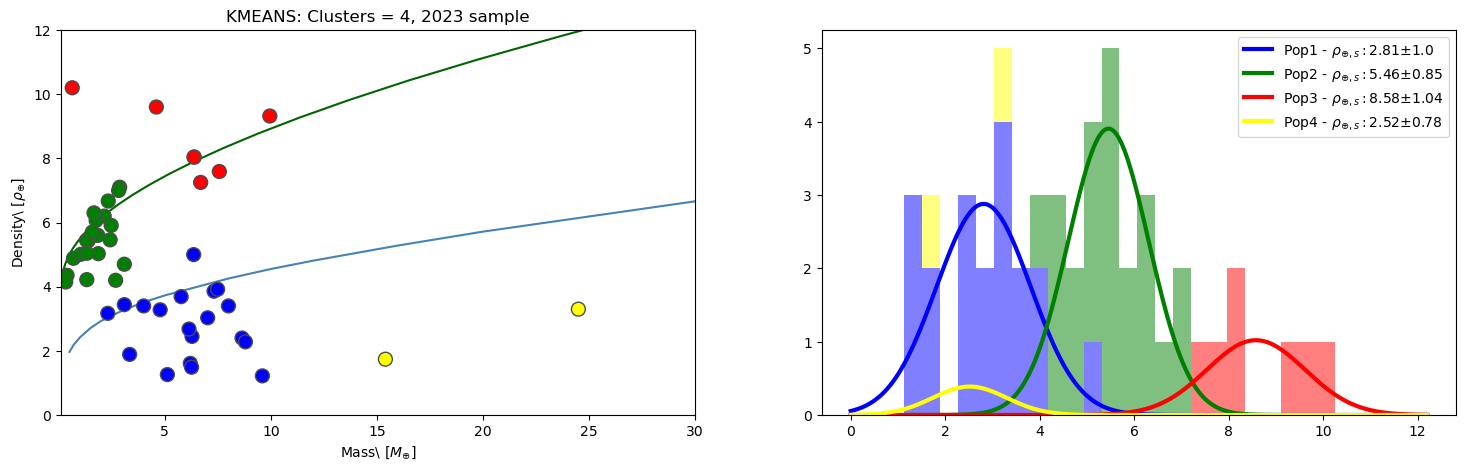

In [986]:
def colorlist(labels):
    color=["0.7",'blue', 'green',"red","yellow"]
    colors = []
    for i in range(len(labels)):
        if labels[i] == -1:
            colors.append(color[0])
        if labels[i] == 0:
            colors.append(color[1])
        if labels[i] == 1:
            colors.append(color[2])
        if labels[i] == 2:
            colors.append(color[3])
        if labels[i] == 3:
            colors.append(color[4])
        if labels[i] == 4:
            colors.append(color[5])
    return colors

fig, ax = plt.subplots(figsize=(18,5))

# Subplot 1
ax = plt.subplot(1, 2, 1)
df = pd.DataFrame({'Mass': mass, 'Density': density})
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(pca_result)
colors = colorlist(clusters)
pop1 = [density[i] for i in range(len(clusters)) if clusters[i] == 0]
pop2 = [density[i] for i in range(len(clusters)) if clusters[i] == 1]
pop3 = [density[i] for i in range(len(clusters)) if clusters[i] == -1]
ax.scatter(mass, density, c=colors, s=100, edgecolor="0.3")
ax.plot(H20_50_500K["Mass"], H20_50_500K_density_g_cm3, "-", color="steelblue", label="50% H2O", zorder=-32)
ax.plot(earth_like_rocky["Mass"], earth_like_rocky_density_g_cm3, "-", color="darkgreen", label="Earth-Like", zorder=-32)
ax.set_xlim(0.1, 30)
ax.set_ylim(0,12)
ax.set_title("KMEANS: Clusters = 2, 2023 sample")
ax.set_xlabel("Mass\ $[M_{\oplus}]$")
ax.set_ylabel("Density\ $[ρ_{\oplus}]$")

# Subplot 2
ax = plt.subplot(1, 2, 2)
bins = np.linspace(0,11,30)
range_min = min(min(pop1), min(pop2))
range_max = max(max(pop1), max(pop2))
hbins  = np.linspace(0, range_max + 2, 1000)
ax.hist([pop1, pop2, pop3], bins=bins, range=(range_min, range_max), alpha=0.5, color=['blue', 'green', "0.7"], stacked=True)
hist_values_false, bin_edges, _ = ax.hist(pop1, bins=bins,range=(range_min, range_max), color='Blue', alpha=0.0, density=False)
area_under_bars = np.sum(hist_values_false * np.diff(bin_edges))
mu = np.average(pop1)
sigma = np.sqrt(np.cov(pop1, ddof=0))
best_fit_line = scipy.stats.norm.pdf(hbins, mu, sigma)*area_under_bars
ax.plot(hbins, best_fit_line,color = "Blue",linewidth=3,label ="Pop1 - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)))

hist_values_false, bin_edges, _ = ax.hist(pop2, bins=bins,range=(range_min, range_max), color='Green', alpha=0.0, density=False)
area_under_bars = np.sum(hist_values_false * np.diff(bin_edges))
mu = np.average(pop2)
sigma = np.sqrt(np.cov(pop2, ddof=0))
best_fit_line = scipy.stats.norm.pdf(hbins, mu, sigma)*area_under_bars
ax.plot(hbins, best_fit_line,color = "Green",linewidth=3,label ="Pop2 - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)))
plt.legend()
ax.set_xlabel("Density\ $[ρ_{\oplus}]$")
ax.set_ylabel("Number of Planets")

fig, ax = plt.subplots(figsize=(18,5))

# Subplot 1
ax = plt.subplot(1, 2, 1)
df = pd.DataFrame({'Mass': mass, 'Density': density})
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(pca_result)
colors = colorlist(clusters)
pop1 = [density[i] for i in range(len(clusters)) if clusters[i] == 0]
pop2 = [density[i] for i in range(len(clusters)) if clusters[i] == 1]
pop3 = [density[i] for i in range(len(clusters)) if clusters[i] == -1]
pop4 = [density[i] for i in range(len(clusters)) if clusters[i] == 2]

ax.scatter(mass, density, c=colors, s=100, edgecolor="0.3")
ax.plot(H20_50_500K["Mass"], H20_50_500K_density_g_cm3, "-", color="steelblue", label="50% H2O", zorder=-32)
ax.plot(earth_like_rocky["Mass"], earth_like_rocky_density_g_cm3, "-", color="darkgreen", label="Earth-Like", zorder=-32)
ax.set_xlim(0.1, 30)
ax.set_ylim(0,12)
ax.set_title("KMEANS: Clusters = 3, 2023 sample")
ax.set_xlabel("Mass\ $[M_{\oplus}]$")
ax.set_ylabel("Density\ $[ρ_{\oplus}]$")

# Subplot 2
ax = plt.subplot(1, 2, 2)
range_min = min(min(pop1), min(pop2))
range_max = max(max(pop1), max(pop2))
ax.hist([pop1, pop2, pop4], bins=bins, range=(range_min, range_max), alpha=0.5, color=['blue', 'green', "red"], stacked=True)

hist_values_false, bin_edges, _ = ax.hist(pop1, bins=bins,range=(range_min, range_max), color='Blue', alpha=0.0, density=False)
area_under_bars = np.sum(hist_values_false * np.diff(bin_edges))
mu = np.average(pop1)
sigma = np.sqrt(np.cov(pop1, ddof=0))
best_fit_line = scipy.stats.norm.pdf(hbins, mu, sigma)*area_under_bars
ax.plot(hbins, best_fit_line,color = "Blue",linewidth=3,label ="Pop1 - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)))

hist_values_false, bin_edges, _ = ax.hist(pop2, bins=bins,range=(range_min, range_max), color='Green', alpha=0.0, density=False)
area_under_bars = np.sum(hist_values_false * np.diff(bin_edges))
mu = np.average(pop2)
sigma = np.sqrt(np.cov(pop2, ddof=0))
best_fit_line = scipy.stats.norm.pdf(hbins, mu, sigma)*area_under_bars
ax.plot(hbins, best_fit_line,color = "Green",linewidth=3,label ="Pop2 - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)))

hist_values_false, bin_edges, _ = ax.hist(pop4, bins=bins,range=(range_min, range_max), color='red', alpha=0.0, density=False)
area_under_bars = np.sum(hist_values_false * np.diff(bin_edges))
mu = np.average(pop2)
sigma = np.sqrt(np.cov(pop4, ddof=0))
best_fit_line = scipy.stats.norm.pdf(hbins, mu, sigma)*area_under_bars
ax.plot(hbins, best_fit_line,color = "red",linewidth=3,label ="Pop3 - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)))


plt.legend()
ax.set_xlabel("Density\ $[ρ_{\oplus}]$")
ax.set_ylabel("Number of Planets")

fig, ax = plt.subplots(figsize=(18,5))

# Subplot 1
ax = plt.subplot(1, 2, 1)
df = pd.DataFrame({'Mass': mass, 'Density': density})
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(pca_result)
colors = colorlist(clusters)
pop1 = [density[i] for i in range(len(clusters)) if clusters[i] == 0]
pop2 = [density[i] for i in range(len(clusters)) if clusters[i] == 1]
pop3 = [density[i] for i in range(len(clusters)) if clusters[i] == -1]
pop4 = [density[i] for i in range(len(clusters)) if clusters[i] == 2]
pop5 = [density[i] for i in range(len(clusters)) if clusters[i] == 3]

ax.scatter(mass, density, c=colors, s=100, edgecolor="0.3")
ax.plot(H20_50_500K["Mass"], H20_50_500K_density_g_cm3, "-", color="steelblue", label="50% H2O", zorder=-32)
ax.plot(earth_like_rocky["Mass"], earth_like_rocky_density_g_cm3, "-", color="darkgreen", label="Earth-Like", zorder=-32)
ax.set_xlim(0.1, 30)
ax.set_ylim(0,12)
ax.set_title("KMEANS: Clusters = 4, 2023 sample")
ax.set_xlabel("Mass\ $[M_{\oplus}]$")
ax.set_ylabel("Density\ $[ρ_{\oplus}]$")

# Subplot 2
ax = plt.subplot(1, 2, 2)
range_min = min(min(pop1), min(pop2))
range_max = max(max(pop1), max(pop2))
ax.hist([pop1, pop2, pop4,pop5], bins=bins, range=(range_min, 10.2), alpha=0.5, color=['blue', 'green', "red","yellow"], stacked=True)

hist_values_false, bin_edges, _ = ax.hist(pop1, bins=bins,range=(range_min, range_max), color='Blue', alpha=0.0, density=False)
area_under_bars = np.sum(hist_values_false * np.diff(bin_edges))
mu = np.average(pop1)
sigma = np.sqrt(np.cov(pop1, ddof=0))
best_fit_line = scipy.stats.norm.pdf(hbins, mu, sigma)*area_under_bars
ax.plot(hbins, best_fit_line,color = "Blue",linewidth=3,label ="Pop1 - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)))

hist_values_false, bin_edges, _ = ax.hist(pop2, bins=bins,range=(range_min, range_max), color='Green', alpha=0.0, density=False)
area_under_bars = np.sum(hist_values_false * np.diff(bin_edges))
mu = np.average(pop2)
sigma = np.sqrt(np.cov(pop2, ddof=0))
best_fit_line = scipy.stats.norm.pdf(hbins, mu, sigma)*area_under_bars
ax.plot(hbins, best_fit_line,color = "Green",linewidth=3,label ="Pop2 - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)))

hist_values_false, bin_edges, _ = ax.hist(pop4, bins=bins,range=(range_min, range_max), color='red', alpha=0.0, density=False)
area_under_bars = np.sum(hist_values_false * np.diff(bin_edges))
mu = np.average(pop4)
sigma = np.sqrt(np.cov(pop4, ddof=0))
best_fit_line = scipy.stats.norm.pdf(hbins, mu, sigma)*area_under_bars
ax.plot(hbins, best_fit_line,color = "red",linewidth=3,label ="Pop3 - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)))

hist_values_false, bin_edges, _ = ax.hist(pop5, bins=bins,range=(range_min, range_max), color='yellow', alpha=0.0, density=False)
area_under_bars = np.sum(hist_values_false * np.diff(bin_edges))
mu = np.average(pop5)
sigma = np.sqrt(np.cov(pop5, ddof=0))
best_fit_line = scipy.stats.norm.pdf(hbins, mu, sigma)*area_under_bars
ax.plot(hbins, best_fit_line,color = "yellow",linewidth=3,label ="Pop4 - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)))
plt.legend()


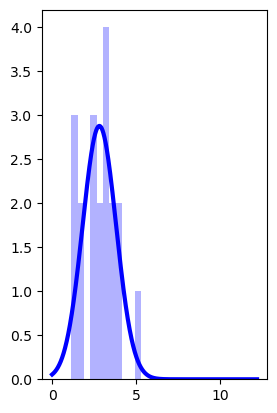

In [984]:
ax = plt.subplot(1, 2, 2)

hist_values_false, bin_edges, _ = ax.hist(pop1, bins=bins,range=(range_min, range_max), color='Blue', alpha=0.3, density=False)
area_under_bars = np.sum(hist_values_false * np.diff(bin_edges))
mu = np.average(pop1)
sigma = np.sqrt(np.cov(pop1, ddof=0))
best_fit_line = scipy.stats.norm.pdf(hbins, mu, sigma)*area_under_bars
ax.plot(hbins, best_fit_line,color = "Blue",linewidth=3,label ="Pop1 - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)))


In [971]:
max(pop4)

10.2

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


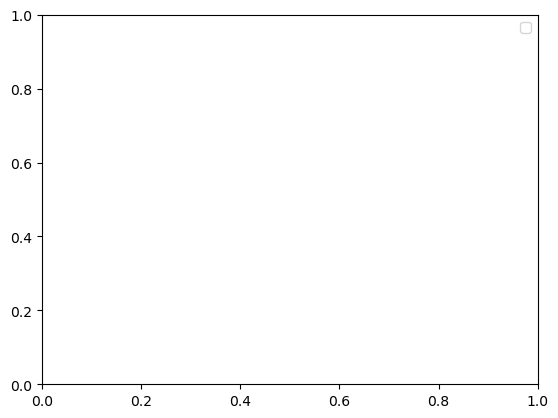

In [964]:
hist_values_false, bin_edges, _ = ax.hist(pop4, bins=bins,range=(range_min, range_max), color='red', alpha=0.3, density=False)
ax.plot(hbins, best_fit_line,color = "Blue",linewidth=3,label ="Pop1 - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)))
plt.legend()


Text(0, 0.5, 'Number of Planets')

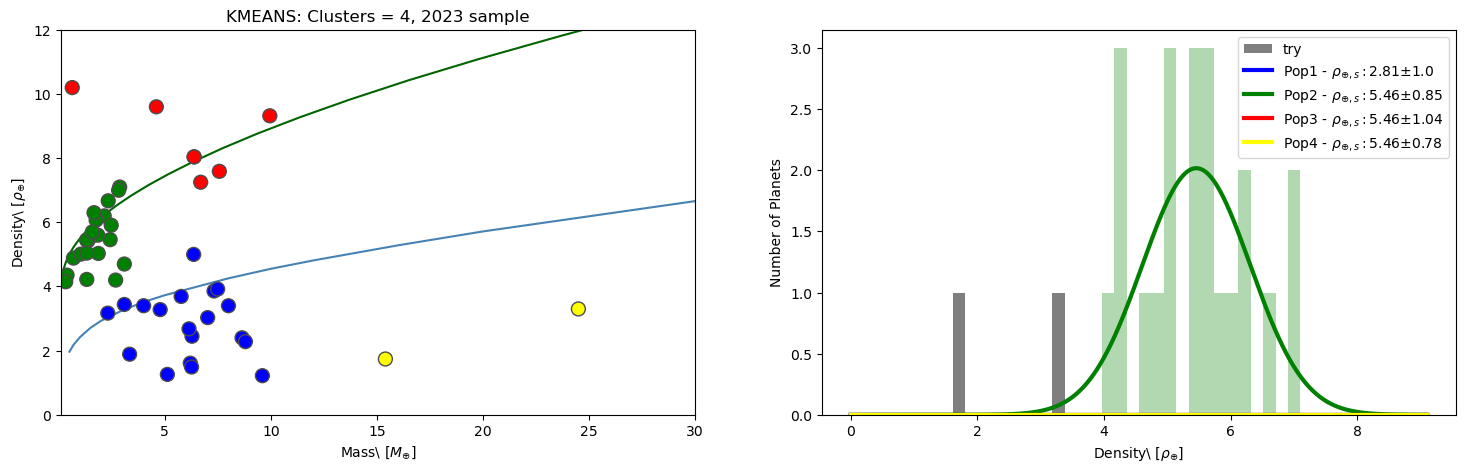

In [960]:

fig, ax = plt.subplots(figsize=(18,5))

# Subplot 1
ax = plt.subplot(1, 2, 1)
df = pd.DataFrame({'Mass': mass, 'Density': density})
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(pca_result)
colors = colorlist(clusters)
pop1 = [density[i] for i in range(len(clusters)) if clusters[i] == 0]
pop2 = [density[i] for i in range(len(clusters)) if clusters[i] == 1]
pop3 = [density[i] for i in range(len(clusters)) if clusters[i] == -1]
pop4 = [density[i] for i in range(len(clusters)) if clusters[i] == 2]
pop5 = [density[i] for i in range(len(clusters)) if clusters[i] == 3]

ax.scatter(mass, density, c=colors, s=100, edgecolor="0.3")
ax.plot(H20_50_500K["Mass"], H20_50_500K_density_g_cm3, "-", color="steelblue", label="50% H2O", zorder=-32)
ax.plot(earth_like_rocky["Mass"], earth_like_rocky_density_g_cm3, "-", color="darkgreen", label="Earth-Like", zorder=-32)
ax.set_xlim(0.1, 30)
ax.set_ylim(0,12)
ax.set_title("KMEANS: Clusters = 4, 2023 sample")
ax.set_xlabel("Mass\ $[M_{\oplus}]$")
ax.set_ylabel("Density\ $[ρ_{\oplus}]$")

# Subplot 2
ax = plt.subplot(1, 2, 2)
bins = 30
hbins  = np.linspace(0, range_max + 2, 1000)
range_min = min(min(pop1), min(pop2))
range_max = max(max(pop1), max(pop2))
#ax.hist([pop1, pop2, pop4,pop5], bins=bins, range=(range_min, range_max), alpha=0.5, label=['pop1', 'pop2', "pop3","pop4"], color=['blue', 'green', "red","yellow"], stacked=True)
ax.hist([pop5], bins=bins, range=(range_min, range_max), alpha=0.5, label=["try"], color=["black"], stacked=True)

#hist_values_false, bin_edges, _ = ax.hist(pop1, bins=bins,range=(range_min, range_max), color='Blue', alpha=0.3, density=False)
area_under_bars = np.sum(hist_values_false * np.diff(bin_edges))
mu = np.average(pop1)
sigma = np.sqrt(np.cov(pop1, ddof=0))
best_fit_line = scipy.stats.norm.pdf(hbins, mu, sigma)*area_under_bars
ax.plot(hbins, best_fit_line,color = "Blue",linewidth=3,label ="Pop1 - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)))

hist_values_false, bin_edges, _ = ax.hist(pop2, bins=bins,range=(range_min, range_max), color='Green', alpha=0.3, density=False)
area_under_bars = np.sum(hist_values_false * np.diff(bin_edges))
mu = np.average(pop2)
sigma = np.sqrt(np.cov(pop2, ddof=0))
best_fit_line = scipy.stats.norm.pdf(hbins, mu, sigma)*area_under_bars
ax.plot(hbins, best_fit_line,color = "Green",linewidth=3,label ="Pop2 - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)))

hist_values_false, bin_edges, _ = ax.hist(pop4, bins=bins,range=(range_min, range_max), color='red', alpha=0.3, density=False)
area_under_bars = np.sum(hist_values_false * np.diff(bin_edges))
mu = np.average(pop2)
sigma = np.sqrt(np.cov(pop4, ddof=0))
best_fit_line = scipy.stats.norm.pdf(hbins, mu, sigma)*area_under_bars
ax.plot(hbins, best_fit_line,color = "red",linewidth=3,label ="Pop3 - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)))

hist_values_false, bin_edges, _ = ax.hist(pop4, bins=bins,range=(range_min, range_max), color='yellow', alpha=0.3, density=False)
area_under_bars = np.sum(hist_values_false * np.diff(bin_edges))
mu = np.average(pop2)
sigma = np.sqrt(np.cov(pop5, ddof=0))
best_fit_line = scipy.stats.norm.pdf(hbins, mu, sigma)*area_under_bars
ax.plot(hbins, best_fit_line,color = "yellow",linewidth=3,label ="Pop4 - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)))

plt.legend()
ax.set_xlabel("Density\ $[ρ_{\oplus}]$")
ax.set_ylabel("Number of Planets")

(0.0, 12.0)

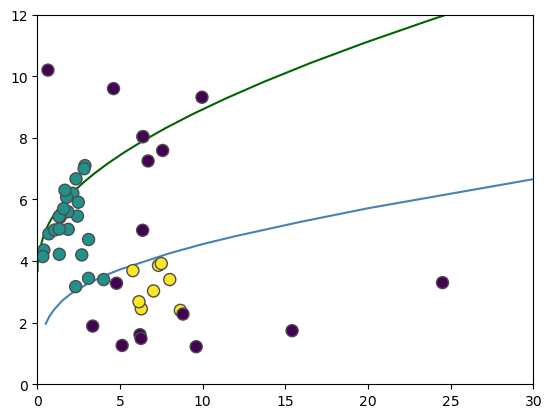

In [816]:
df = pd.DataFrame({'Mass': mass, 'Density': density})

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

dbscan = DBSCAN(eps=0.52, min_samples=8,metric = "euclidean")
dbscan.fit(scaled_data)
clusters = dbscan.fit_predict(pca_result)

plt.scatter(mass, density, c=clusters, s=75, edgecolor="0.3", cmap='viridis')
plt.plot(H20_50_500K["Mass"], H20_50_500K_density_g_cm3, "-", color="steelblue", label="50% H2O", zorder=-32)
plt.plot(earth_like_rocky["Mass"], earth_like_rocky_density_g_cm3, "-", color="darkgreen", label="Earth-Like", zorder=-32)
plt.xlim(0,30)
plt.ylim(0,12)

In [808]:
esps = np.linspace(0.1,4, 1000)
epsilons = []
silhouette_avg = []
calinski_harabasz_index = []

for i in range(0,len(esps)):
    dbscan = DBSCAN(eps=esps[i], min_samples=8,metric = "euclidean")
    dbscan.fit(pca_result)
    clusters = dbscan.fit_predict(pca_result)
    if 1 in clusters:
        silhouette_avg.append(silhouette_score(pca_result[clusters != -1], clusters[clusters != -1]))
        calinski_harabasz_index.append(calinski_harabasz_score(pca_result[clusters != -1], clusters[clusters != -1]))
        epsilons.append(esps[i])

DBSCAN: min_samples = 4, ε = 0.32
Silhouette Score:        0.55
Calinski-Harabasz index: 51.23

DBSCAN: min_samples = 5, ε = 0.40
Silhouette Score:        0.58
Calinski-Harabasz index: 58.08

DBSCAN: min_samples = 6, ε = 0.43
Silhouette Score:        0.67
Calinski-Harabasz index: 62.59

DBSCAN: min_samples = 7, ε = 0.45
Silhouette Score:        0.63
Calinski-Harabasz index: 56.24

DBSCAN: min_samples = 8, ε = 0.49
Silhouette Score:        0.58
Calinski-Harabasz index: 59.57

DBSCAN: min_samples = 9, ε = 0.605
Silhouette Score:        0.59
Calinski-Harabasz index: 71.89



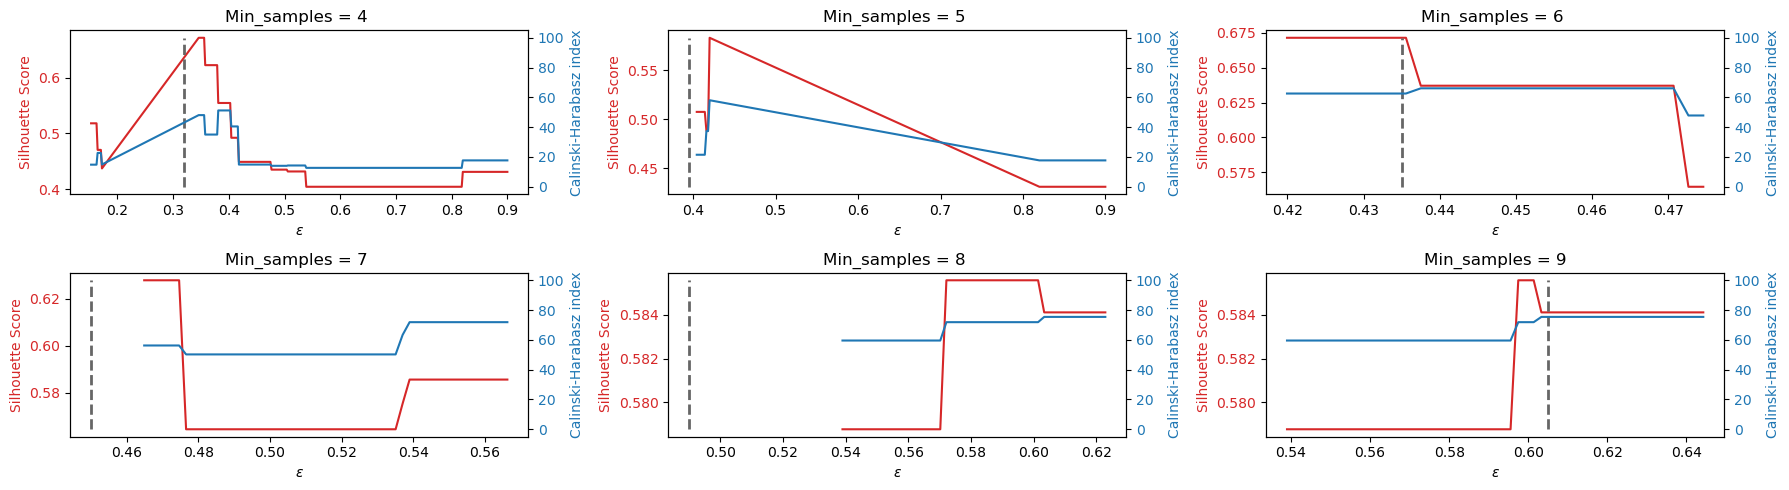

In [11]:
fig, ax = plt.subplots(figsize=(18,5))
df = pd.DataFrame({'Mass': mass, 'Density': density})

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)


esps = np.linspace(0.1,4, 2000)

####  MIN_SAMPLE = 4 #####
epsilons = []
silhouette_avg = []
calinski_harabasz_index = []

for i in range(0,len(esps)):
    dbscan = DBSCAN(eps=esps[i], min_samples=4,metric = "euclidean")
    dbscan.fit(pca_result)
    clusters = dbscan.fit_predict(pca_result)
    if 1 in clusters:
        silhouette_avg.append(silhouette_score(pca_result[clusters != -1], clusters[clusters != -1]))
        calinski_harabasz_index.append(calinski_harabasz_score(pca_result[clusters != -1], clusters[clusters != -1]))
        epsilons.append(esps[i])
        
ax = plt.subplot(2, 3, 1)
ax1 = ax
ax2 = ax.twinx()
plt.title("Min_samples = 4 ")
color = 'tab:red'
ax1.set_xlabel("$\epsilon$")
ax1.set_ylabel("Silhouette Score", color=color)
ax1.plot(epsilons, silhouette_avg, color=color)
ax1.tick_params(axis='y', labelcolor=color)

color = 'tab:blue'
ax2.set_ylabel('Calinski-Harabasz index', color=color)
ax2.plot(epsilons, calinski_harabasz_index, color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.yticks([0,20,40,60,80,100])

fig.tight_layout()
plt.vlines(0.32,0,100,colors = "0.4",linestyle = "dashed",zorder=-32,linewidth = 2)

max_value = max(calinski_harabasz_index)
max_index = calinski_harabasz_index.index(max_value)
print("DBSCAN: min_samples = 4, ε = 0.32")
print("Silhouette Score:        " + str(np.round(silhouette_avg[max_index],2)))
print("Calinski-Harabasz index: " + str(np.round(calinski_harabasz_index[max_index],2)))
print("")

####  MIN_SAMPLE = 5 #####
epsilons = []
silhouette_avg = []
calinski_harabasz_index = []

for i in range(0,len(esps)):
    dbscan = DBSCAN(eps=esps[i], min_samples=5,metric = "euclidean")
    dbscan.fit(pca_result)
    clusters = dbscan.fit_predict(pca_result)
    if 1 in clusters:
        silhouette_avg.append(silhouette_score(pca_result[clusters != -1], clusters[clusters != -1]))
        calinski_harabasz_index.append(calinski_harabasz_score(pca_result[clusters != -1], clusters[clusters != -1]))
        epsilons.append(esps[i])


ax = plt.subplot(2, 3, 2)
ax1 = ax
ax2 = ax.twinx()
plt.title("Min_samples = 5 ")
plt.vlines(0.395,0,100,colors = "0.4",linestyle = "dashed",zorder=-32,linewidth = 2)

color = 'tab:red'
ax1.set_xlabel("$\epsilon$")
ax1.set_ylabel("Silhouette Score", color=color)
ax1.plot(epsilons, silhouette_avg, color=color)
ax1.tick_params(axis='y', labelcolor=color)

color = 'tab:blue'
ax2.set_ylabel('Calinski-Harabasz index', color=color)
ax2.plot(epsilons, calinski_harabasz_index, color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.yticks([0,20,40,60,80,100])

fig.tight_layout()

max_value = max(calinski_harabasz_index)
max_index = calinski_harabasz_index.index(max_value)
print("DBSCAN: min_samples = 5, ε = 0.40")
print("Silhouette Score:        " + str(np.round(silhouette_avg[max_index],2)))
print("Calinski-Harabasz index: " + str(np.round(calinski_harabasz_index[max_index],2)))
print("")

####  MIN_SAMPLE = 6 #####
epsilons = []
silhouette_avg = []
calinski_harabasz_index = []

for i in range(0,len(esps)):
    dbscan = DBSCAN(eps=esps[i], min_samples=6,metric = "euclidean")
    dbscan.fit(pca_result)
    clusters = dbscan.fit_predict(pca_result)
    if 1 in clusters:
        silhouette_avg.append(silhouette_score(pca_result[clusters != -1], clusters[clusters != -1]))
        calinski_harabasz_index.append(calinski_harabasz_score(pca_result[clusters != -1], clusters[clusters != -1]))
        epsilons.append(esps[i])

ax = plt.subplot(2, 3, 3)

ax1 = ax
ax2 = ax.twinx()
plt.title("Min_samples = 6 ")

color = 'tab:red'
ax1.set_xlabel("$\epsilon$")
ax1.set_ylabel("Silhouette Score", color=color)
ax1.plot(epsilons, silhouette_avg, color=color)
ax1.tick_params(axis='y', labelcolor=color)

color = 'tab:blue'
ax2.set_ylabel('Calinski-Harabasz index', color=color)
ax2.plot(epsilons, calinski_harabasz_index, color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.yticks([0,20,40,60,80,100])

fig.tight_layout()
plt.vlines(0.435,0,100,colors = "0.4",linestyle = "dashed",zorder=-32,linewidth = 2)
print("DBSCAN: min_samples = 6, ε = 0.43")
print("Silhouette Score:        " + str(np.round(silhouette_avg[0],2)))
print("Calinski-Harabasz index: " + str(np.round(calinski_harabasz_index[0],2)))
print("")

####  MIN_SAMPLE = 7 #####
epsilons = []
silhouette_avg = []
calinski_harabasz_index = []

for i in range(0,len(esps)):
    dbscan = DBSCAN(eps=esps[i], min_samples=7,metric = "euclidean")
    dbscan.fit(pca_result)
    clusters = dbscan.fit_predict(pca_result)
    if 1 in clusters:
        silhouette_avg.append(silhouette_score(pca_result[clusters != -1], clusters[clusters != -1]))
        calinski_harabasz_index.append(calinski_harabasz_score(pca_result[clusters != -1], clusters[clusters != -1]))
        epsilons.append(esps[i])


ax = plt.subplot(2, 3, 4)
ax1 = ax
ax2 = ax.twinx()
plt.title("Min_samples = 7 ")

color = 'tab:red'
ax1.set_xlabel("$\epsilon$")
ax1.set_ylabel("Silhouette Score", color=color)
ax1.plot(epsilons, silhouette_avg, color=color)
ax1.tick_params(axis='y', labelcolor=color)

color = 'tab:blue'
ax2.set_ylabel('Calinski-Harabasz index', color=color)
ax2.plot(epsilons, calinski_harabasz_index, color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.yticks([0,20,40,60,80,100])
plt.yticks([0,20,40,60,80,100])

fig.tight_layout()
plt.vlines(0.45,0,100,colors = "0.4",linestyle = "dashed",zorder=-32,linewidth = 2)
print("DBSCAN: min_samples = 7, ε = 0.45")
print("Silhouette Score:        " + str(np.round(silhouette_avg[0],2)))
print("Calinski-Harabasz index: " + str(np.round(calinski_harabasz_index[0],2)))
print("")


####  MIN_SAMPLE = 8 #####
epsilons = []
silhouette_avg = []
calinski_harabasz_index = []

for i in range(0,len(esps)):
    dbscan = DBSCAN(eps=esps[i], min_samples=8,metric = "euclidean")
    dbscan.fit(pca_result)
    clusters = dbscan.fit_predict(pca_result)
    if 1 in clusters:
        silhouette_avg.append(silhouette_score(pca_result[clusters != -1], clusters[clusters != -1]))
        calinski_harabasz_index.append(calinski_harabasz_score(pca_result[clusters != -1], clusters[clusters != -1]))
        epsilons.append(esps[i])
        

ax = plt.subplot(2, 3, 5)
ax1 = ax
ax2 = ax.twinx()
plt.title("Min_samples = 8 ")

color = 'tab:red'
ax1.set_xlabel("$\epsilon$")
ax1.set_ylabel("Silhouette Score", color=color)
ax1.plot(epsilons, silhouette_avg, color=color)
ax1.tick_params(axis='y', labelcolor=color)

color = 'tab:blue'
ax2.set_ylabel('Calinski-Harabasz index', color=color)
ax2.plot(epsilons, calinski_harabasz_index, color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.yticks([0,20,40,60,80,100])

fig.tight_layout()

plt.vlines(0.49,0,100,colors = "0.4",linestyle = "dashed",zorder=-32,linewidth = 2)



####  MIN_SAMPLE = 9 #####
epsilons = []
silhouette_avg = []
calinski_harabasz_index = []

for i in range(0,len(esps)):
    dbscan = DBSCAN(eps=esps[i], min_samples=9,metric = "euclidean")
    dbscan.fit(pca_result)
    clusters = dbscan.fit_predict(pca_result)
    if 1 in clusters:
        silhouette_avg.append(silhouette_score(pca_result[clusters != -1], clusters[clusters != -1]))
        calinski_harabasz_index.append(calinski_harabasz_score(pca_result[clusters != -1], clusters[clusters != -1]))
        epsilons.append(esps[i])

print("DBSCAN: min_samples = 8, ε = 0.49")
print("Silhouette Score:        " + str(np.round(silhouette_avg[0],2)))
print("Calinski-Harabasz index: " + str(np.round(calinski_harabasz_index[0],2)))
print("")

ax = plt.subplot(2, 3, 6)
ax1 = ax
ax2 = ax.twinx()
plt.title("Min_samples = 9")

color = 'tab:red'
ax1.set_xlabel("$\epsilon$")
ax1.set_ylabel("Silhouette Score", color=color)
ax1.plot(epsilons, silhouette_avg, color=color)
ax1.tick_params(axis='y', labelcolor=color)

color = 'tab:blue'
ax2.set_ylabel('Calinski-Harabasz index', color=color)
ax2.plot(epsilons, calinski_harabasz_index, color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.yticks([0,20,40,60,80,100])
plt.vlines(0.605,0,100,colors = "0.4",linestyle = "dashed",zorder=-32,linewidth = 2)

fig.tight_layout()

max_value = max(silhouette_avg)
max_index = silhouette_avg.index(max_value)
print("DBSCAN: min_samples = 9, ε = 0.605")
print("Silhouette Score:        " + str(np.round(silhouette_avg[max_index],2)))
print("Calinski-Harabasz index: " + str(np.round(calinski_harabasz_index[max_index],2)))
print("")

(0.0, 12.0)

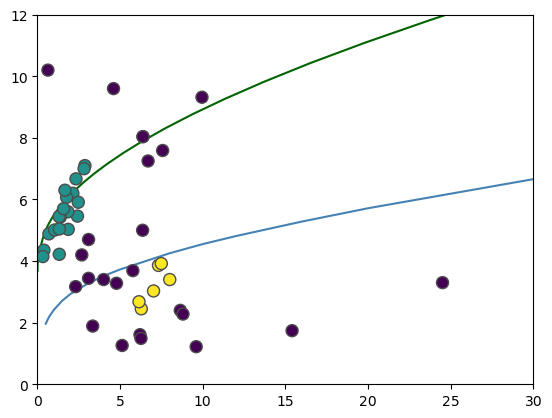

In [925]:
df = pd.DataFrame({'Mass': mass, 'Density': density})

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

dbscan = DBSCAN(eps=0.32046023011505753, min_samples=4,metric = "euclidean")
dbscan.fit(scaled_data)
clusters = dbscan.fit_predict(pca_result)

plt.scatter(mass, density, c=clusters, s=75, edgecolor="0.3", cmap='viridis')
plt.plot(H20_50_500K["Mass"], H20_50_500K_density_g_cm3, "-", color="steelblue", label="50% H2O", zorder=-32)
plt.plot(earth_like_rocky["Mass"], earth_like_rocky_density_g_cm3, "-", color="darkgreen", label="Earth-Like", zorder=-32)
plt.xlim(0,30)
plt.ylim(0,12)

Text(0, 0.5, 'Number of Planets')

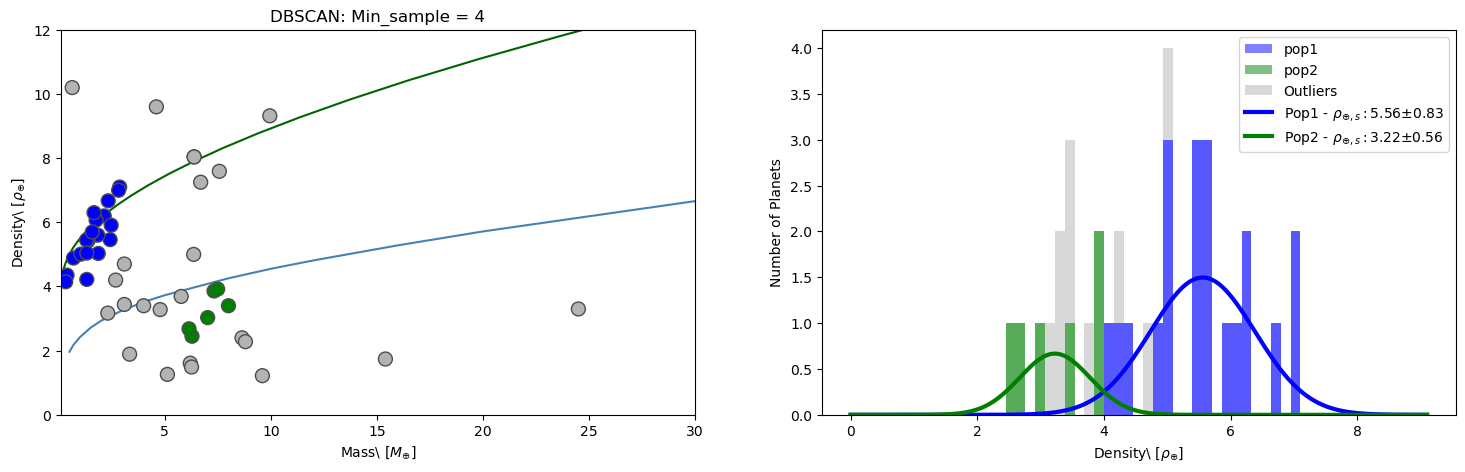

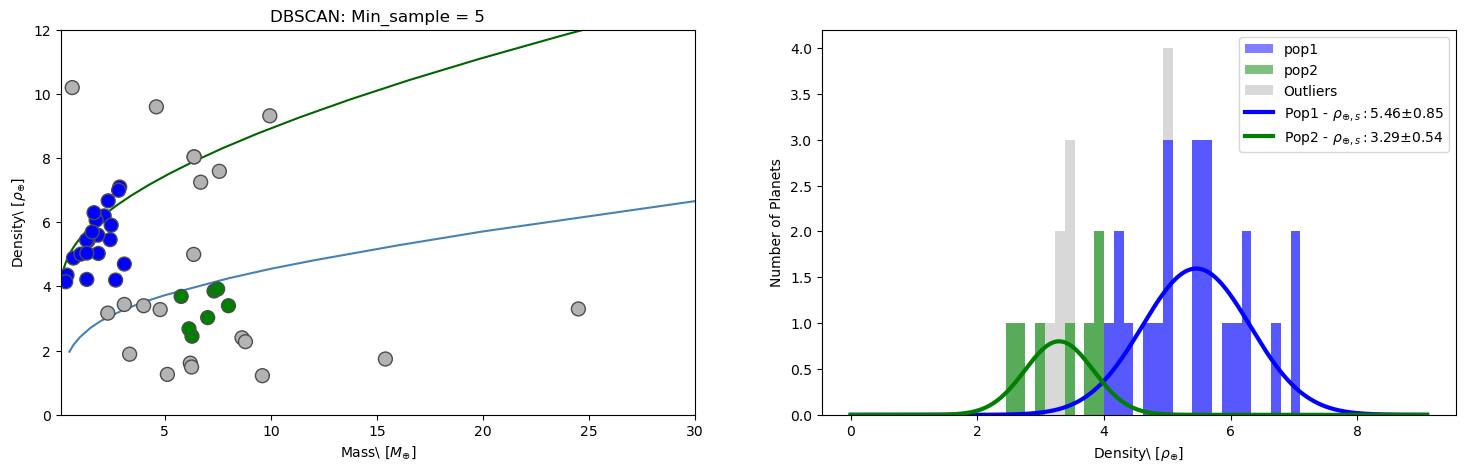

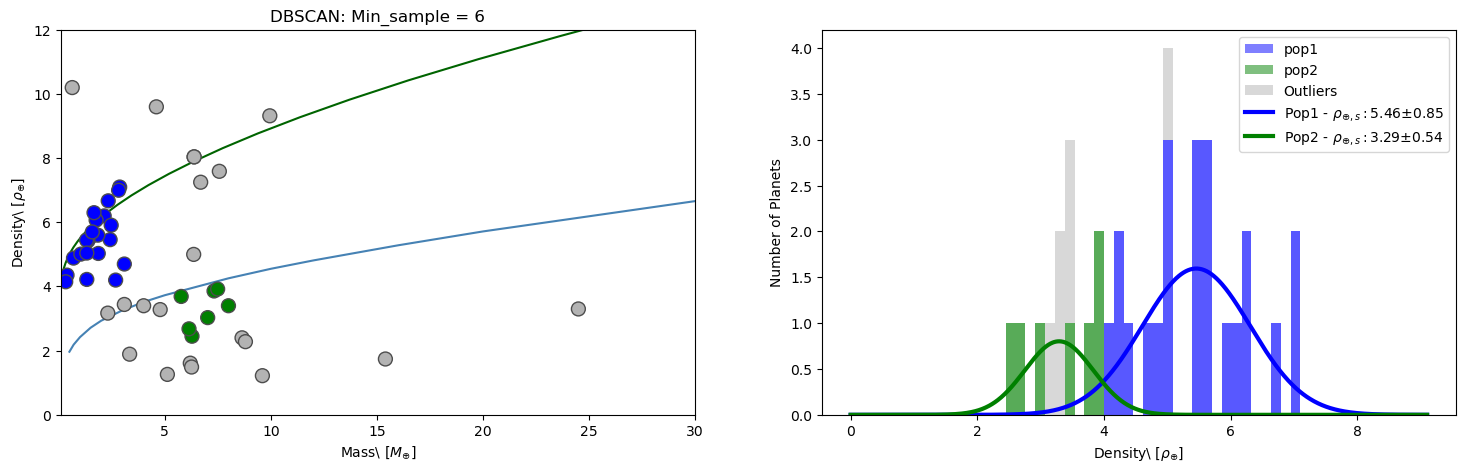

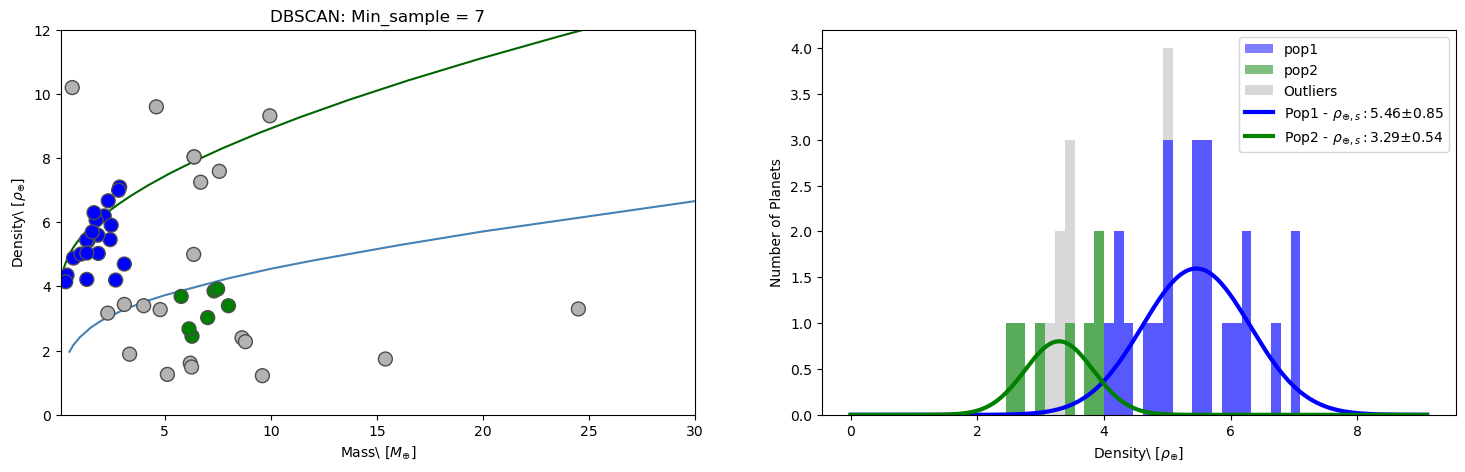

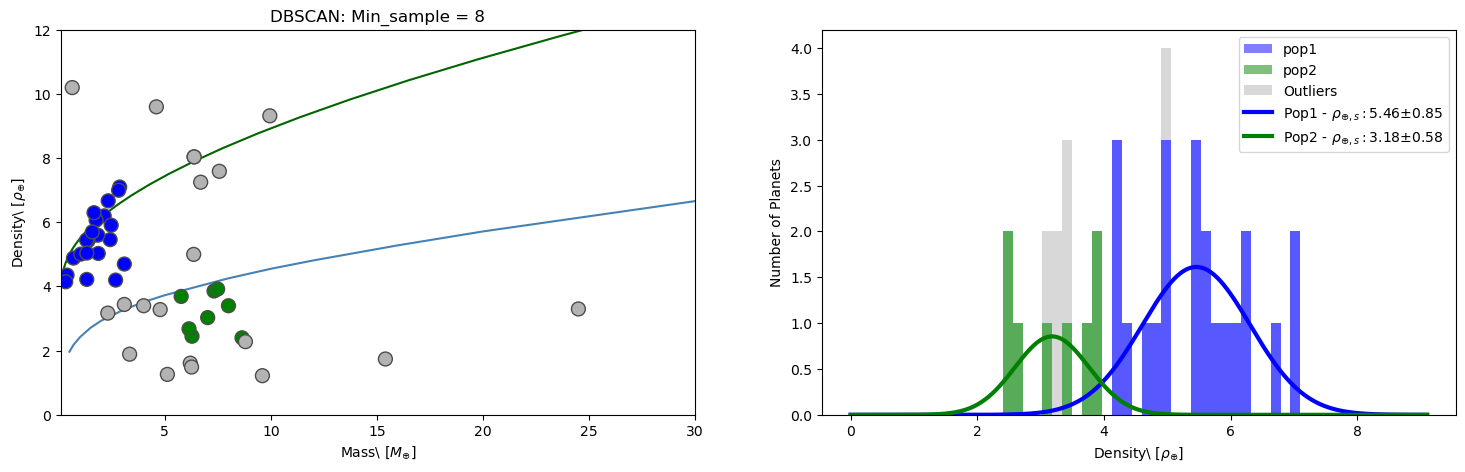

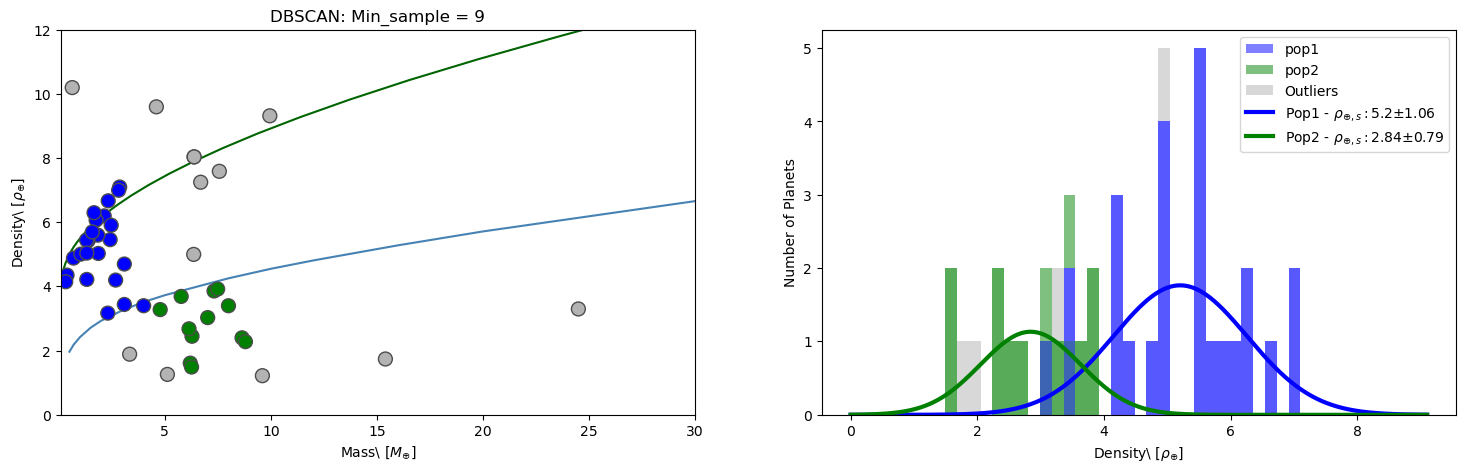

In [933]:
def colorlist(labels):
    color=["0.7",'blue', 'green']
    colors = []
    for i in range(len(labels)):
        if labels[i] == -1:
            colors.append(color[0])
        if labels[i] == 0:
            colors.append(color[1])
        if labels[i] == 1:
            colors.append(color[2])
        if labels[i] == 2:
            colors.append(color[3])
        if labels[i] == 3:
            colors.append(color[4])
        if labels[i] == 4:
            colors.append(color[5])
    return colors


fig, ax = plt.subplots(figsize=(18,5))

# Subplot 1
ax = plt.subplot(1, 2, 1)
df = pd.DataFrame({'Mass': mass, 'Density': density})
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)
dbscan = DBSCAN(eps=0.32046023011505753, min_samples=4,metric = "euclidean")
dbscan.fit(scaled_data)
clusters = dbscan.fit_predict(pca_result)
colors = colorlist(clusters)
pop1 = [density[i] for i in range(len(clusters)) if clusters[i] == 0]
pop2 = [density[i] for i in range(len(clusters)) if clusters[i] == 1]
pop3 = [density[i] for i in range(len(clusters)) if clusters[i] == -1]
ax.scatter(mass, density, c=colors, s=100, edgecolor="0.3")
ax.plot(H20_50_500K["Mass"], H20_50_500K_density_g_cm3, "-", color="steelblue", label="50% H2O", zorder=-32)
ax.plot(earth_like_rocky["Mass"], earth_like_rocky_density_g_cm3, "-", color="darkgreen", label="Earth-Like", zorder=-32)
ax.set_xlim(0.1, 30)
ax.set_ylim(0,12)
ax.set_title("DBSCAN: Min_sample = 4")
ax.set_xlabel("Mass\ $[M_{\oplus}]$")
ax.set_ylabel("Density\ $[ρ_{\oplus}]$")

# Subplot 2
ax = plt.subplot(1, 2, 2)
bins = 30
range_min = min(min(pop1), min(pop2))
range_max = max(max(pop1), max(pop2))
hbins  = np.linspace(0, range_max + 2, 1000)
ax.hist([pop1, pop2, pop3], bins=bins, range=(range_min, range_max), alpha=0.5, label=['pop1', 'pop2', 'Outliers'], color=['blue', 'green', "0.7"], stacked=True)
hist_values_false, bin_edges, _ = ax.hist(pop1, bins=bins,range=(range_min, range_max), color='Blue', alpha=0.3, density=False)
area_under_bars = np.sum(hist_values_false * np.diff(bin_edges))
mu = np.average(pop1)
sigma = np.sqrt(np.cov(pop1, ddof=0))
best_fit_line = scipy.stats.norm.pdf(hbins, mu, sigma)*area_under_bars
ax.plot(hbins, best_fit_line,color = "Blue",linewidth=3,label ="Pop1 - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)))

hist_values_false, bin_edges, _ = ax.hist(pop2, bins=bins,range=(range_min, range_max), color='Green', alpha=0.3, density=False)
area_under_bars = np.sum(hist_values_false * np.diff(bin_edges))
mu = np.average(pop2)
sigma = np.sqrt(np.cov(pop2, ddof=0))
best_fit_line = scipy.stats.norm.pdf(hbins, mu, sigma)*area_under_bars
ax.plot(hbins, best_fit_line,color = "Green",linewidth=3,label ="Pop2 - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)))
plt.legend()
ax.set_xlabel("Density\ $[ρ_{\oplus}]$")
ax.set_ylabel("Number of Planets")




fig, ax = plt.subplots(figsize=(18,5))

# Subplot 1
ax = plt.subplot(1, 2, 1)
df = pd.DataFrame({'Mass': mass, 'Density': density})
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)
dbscan = DBSCAN(eps=0.40, min_samples=5,metric = "euclidean")
dbscan.fit(scaled_data)
clusters = dbscan.fit_predict(pca_result)
colors = colorlist(clusters)
pop1 = [density[i] for i in range(len(clusters)) if clusters[i] == 0]
pop2 = [density[i] for i in range(len(clusters)) if clusters[i] == 1]
pop3 = [density[i] for i in range(len(clusters)) if clusters[i] == -1]
ax.scatter(mass, density, c=colors, s=100, edgecolor="0.3")
ax.plot(H20_50_500K["Mass"], H20_50_500K_density_g_cm3, "-", color="steelblue", label="50% H2O", zorder=-32)
ax.plot(earth_like_rocky["Mass"], earth_like_rocky_density_g_cm3, "-", color="darkgreen", label="Earth-Like", zorder=-32)
ax.set_xlim(0.1, 30)
ax.set_ylim(0,12)
ax.set_title("DBSCAN: Min_sample = 5")
ax.set_xlabel("Mass\ $[M_{\oplus}]$")
ax.set_ylabel("Density\ $[ρ_{\oplus}]$")

# Subplot 2
ax = plt.subplot(1, 2, 2)
bins = 30
range_min = min(min(pop1), min(pop2))
range_max = max(max(pop1), max(pop2))
hbins  = np.linspace(0, range_max + 2, 1000)
ax.hist([pop1, pop2, pop3], bins=bins, range=(range_min, range_max), alpha=0.5, label=['pop1', 'pop2', 'Outliers'], color=['blue', 'green', "0.7"], stacked=True)
hist_values_false, bin_edges, _ = ax.hist(pop1, bins=bins,range=(range_min, range_max), color='Blue', alpha=0.3, density=False)
area_under_bars = np.sum(hist_values_false * np.diff(bin_edges))
mu = np.average(pop1)
sigma = np.sqrt(np.cov(pop1, ddof=0))
best_fit_line = scipy.stats.norm.pdf(hbins, mu, sigma)*area_under_bars
ax.plot(hbins, best_fit_line,color = "Blue",linewidth=3,label ="Pop1 - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)))

hist_values_false, bin_edges, _ = ax.hist(pop2, bins=bins,range=(range_min, range_max), color='Green', alpha=0.3, density=False)
area_under_bars = np.sum(hist_values_false * np.diff(bin_edges))
mu = np.average(pop2)
sigma = np.sqrt(np.cov(pop2, ddof=0))
best_fit_line = scipy.stats.norm.pdf(hbins, mu, sigma)*area_under_bars
ax.plot(hbins, best_fit_line,color = "Green",linewidth=3,label ="Pop2 - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)))
plt.legend()
ax.set_xlabel("Density\ $[ρ_{\oplus}]$")
ax.set_ylabel("Number of Planets")

fig, ax = plt.subplots(figsize=(18,5))

# Subplot 1
ax = plt.subplot(1, 2, 1)
df = pd.DataFrame({'Mass': mass, 'Density': density})
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)
dbscan = DBSCAN(eps=0.43, min_samples=6,metric = "euclidean")
dbscan.fit(scaled_data)
clusters = dbscan.fit_predict(pca_result)
colors = colorlist(clusters)
pop1 = [density[i] for i in range(len(clusters)) if clusters[i] == 0]
pop2 = [density[i] for i in range(len(clusters)) if clusters[i] == 1]
pop3 = [density[i] for i in range(len(clusters)) if clusters[i] == -1]
ax.scatter(mass, density, c=colors, s=100, edgecolor="0.3")
ax.plot(H20_50_500K["Mass"], H20_50_500K_density_g_cm3, "-", color="steelblue", label="50% H2O", zorder=-32)
ax.plot(earth_like_rocky["Mass"], earth_like_rocky_density_g_cm3, "-", color="darkgreen", label="Earth-Like", zorder=-32)
ax.set_xlim(0.1, 30)
ax.set_ylim(0,12)
ax.set_title("DBSCAN: Min_sample = 6")
ax.set_xlabel("Mass\ $[M_{\oplus}]$")
ax.set_ylabel("Density\ $[ρ_{\oplus}]$")

# Subplot 2
ax = plt.subplot(1, 2, 2)
bins = 30
range_min = min(min(pop1), min(pop2))
range_max = max(max(pop1), max(pop2))
hbins  = np.linspace(0, range_max + 2, 1000)
ax.hist([pop1, pop2, pop3], bins=bins, range=(range_min, range_max), alpha=0.5, label=['pop1', 'pop2', 'Outliers'], color=['blue', 'green', "0.7"], stacked=True)
hist_values_false, bin_edges, _ = ax.hist(pop1, bins=bins,range=(range_min, range_max), color='Blue', alpha=0.3, density=False)
area_under_bars = np.sum(hist_values_false * np.diff(bin_edges))
mu = np.average(pop1)
sigma = np.sqrt(np.cov(pop1, ddof=0))
best_fit_line = scipy.stats.norm.pdf(hbins, mu, sigma)*area_under_bars
ax.plot(hbins, best_fit_line,color = "Blue",linewidth=3,label ="Pop1 - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)))

hist_values_false, bin_edges, _ = ax.hist(pop2, bins=bins,range=(range_min, range_max), color='Green', alpha=0.3, density=False)
area_under_bars = np.sum(hist_values_false * np.diff(bin_edges))
mu = np.average(pop2)
sigma = np.sqrt(np.cov(pop2, ddof=0))
best_fit_line = scipy.stats.norm.pdf(hbins, mu, sigma)*area_under_bars
ax.plot(hbins, best_fit_line,color = "Green",linewidth=3,label ="Pop2 - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)))
plt.legend()
ax.set_xlabel("Density\ $[ρ_{\oplus}]$")
ax.set_ylabel("Number of Planets")



fig, ax = plt.subplots(figsize=(18,5))

# Subplot 1
ax = plt.subplot(1, 2, 1)
df = pd.DataFrame({'Mass': mass, 'Density': density})
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)
dbscan = DBSCAN(eps=0.45, min_samples=7,metric = "euclidean")
dbscan.fit(scaled_data)
clusters = dbscan.fit_predict(pca_result)
colors = colorlist(clusters)
pop1 = [density[i] for i in range(len(clusters)) if clusters[i] == 0]
pop2 = [density[i] for i in range(len(clusters)) if clusters[i] == 1]
pop3 = [density[i] for i in range(len(clusters)) if clusters[i] == -1]
ax.scatter(mass, density, c=colors, s=100, edgecolor="0.3")
ax.plot(H20_50_500K["Mass"], H20_50_500K_density_g_cm3, "-", color="steelblue", label="50% H2O", zorder=-32)
ax.plot(earth_like_rocky["Mass"], earth_like_rocky_density_g_cm3, "-", color="darkgreen", label="Earth-Like", zorder=-32)
ax.set_xlim(0.1, 30)
ax.set_ylim(0,12)
ax.set_title("DBSCAN: Min_sample = 7")
ax.set_xlabel("Mass\ $[M_{\oplus}]$")
ax.set_ylabel("Density\ $[ρ_{\oplus}]$")

# Subplot 2
ax = plt.subplot(1, 2, 2)
bins = 30
range_min = min(min(pop1), min(pop2))
range_max = max(max(pop1), max(pop2))
hbins  = np.linspace(0, range_max + 2, 1000)
ax.hist([pop1, pop2, pop3], bins=bins, range=(range_min, range_max), alpha=0.5, label=['pop1', 'pop2', 'Outliers'], color=['blue', 'green', "0.7"], stacked=True)
hist_values_false, bin_edges, _ = ax.hist(pop1, bins=bins,range=(range_min, range_max), color='Blue', alpha=0.3, density=False)
area_under_bars = np.sum(hist_values_false * np.diff(bin_edges))
mu = np.average(pop1)
sigma = np.sqrt(np.cov(pop1, ddof=0))
best_fit_line = scipy.stats.norm.pdf(hbins, mu, sigma)*area_under_bars
ax.plot(hbins, best_fit_line,color = "Blue",linewidth=3,label ="Pop1 - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)))

hist_values_false, bin_edges, _ = ax.hist(pop2, bins=bins,range=(range_min, range_max), color='Green', alpha=0.3, density=False)
area_under_bars = np.sum(hist_values_false * np.diff(bin_edges))
mu = np.average(pop2)
sigma = np.sqrt(np.cov(pop2, ddof=0))
best_fit_line = scipy.stats.norm.pdf(hbins, mu, sigma)*area_under_bars
ax.plot(hbins, best_fit_line,color = "Green",linewidth=3,label ="Pop2 - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)))
plt.legend()
ax.set_xlabel("Density\ $[ρ_{\oplus}]$")
ax.set_ylabel("Number of Planets")




fig, ax = plt.subplots(figsize=(18,5))

# Subplot 1
ax = plt.subplot(1, 2, 1)
df = pd.DataFrame({'Mass': mass, 'Density': density})
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)
dbscan = DBSCAN(eps=0.49, min_samples=8,metric = "euclidean")
dbscan.fit(scaled_data)
clusters = dbscan.fit_predict(pca_result)
colors = colorlist(clusters)
pop1 = [density[i] for i in range(len(clusters)) if clusters[i] == 0]
pop2 = [density[i] for i in range(len(clusters)) if clusters[i] == 1]
pop3 = [density[i] for i in range(len(clusters)) if clusters[i] == -1]
ax.scatter(mass, density, c=colors, s=100, edgecolor="0.3")
ax.plot(H20_50_500K["Mass"], H20_50_500K_density_g_cm3, "-", color="steelblue", label="50% H2O", zorder=-32)
ax.plot(earth_like_rocky["Mass"], earth_like_rocky_density_g_cm3, "-", color="darkgreen", label="Earth-Like", zorder=-32)
ax.set_xlim(0.1, 30)
ax.set_ylim(0,12)
ax.set_title("DBSCAN: Min_sample = 8")
ax.set_xlabel("Mass\ $[M_{\oplus}]$")
ax.set_ylabel("Density\ $[ρ_{\oplus}]$")

# Subplot 2
ax = plt.subplot(1, 2, 2)
bins = 30
range_min = min(min(pop1), min(pop2))
range_max = max(max(pop1), max(pop2))
hbins  = np.linspace(0, range_max + 2, 1000)
ax.hist([pop1, pop2, pop3], bins=bins, range=(range_min, range_max), alpha=0.5, label=['pop1', 'pop2', 'Outliers'], color=['blue', 'green', "0.7"], stacked=True)
hist_values_false, bin_edges, _ = ax.hist(pop1, bins=bins,range=(range_min, range_max), color='Blue', alpha=0.3, density=False)
area_under_bars = np.sum(hist_values_false * np.diff(bin_edges))
mu = np.average(pop1)
sigma = np.sqrt(np.cov(pop1, ddof=0))
best_fit_line = scipy.stats.norm.pdf(hbins, mu, sigma)*area_under_bars
ax.plot(hbins, best_fit_line,color = "Blue",linewidth=3,label ="Pop1 - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)))

hist_values_false, bin_edges, _ = ax.hist(pop2, bins=bins,range=(range_min, range_max), color='Green', alpha=0.3, density=False)
area_under_bars = np.sum(hist_values_false * np.diff(bin_edges))
mu = np.average(pop2)
sigma = np.sqrt(np.cov(pop2, ddof=0))
best_fit_line = scipy.stats.norm.pdf(hbins, mu, sigma)*area_under_bars
ax.plot(hbins, best_fit_line,color = "Green",linewidth=3,label ="Pop2 - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)))
plt.legend()
ax.set_xlabel("Density\ $[ρ_{\oplus}]$")
ax.set_ylabel("Number of Planets")


fig, ax = plt.subplots(figsize=(18,5))

# Subplot 1
ax = plt.subplot(1, 2, 1)
df = pd.DataFrame({'Mass': mass, 'Density': density})
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)
dbscan = DBSCAN(eps=0.605, min_samples=9,metric = "euclidean")
dbscan.fit(scaled_data)
clusters = dbscan.fit_predict(pca_result)
colors = colorlist(clusters)
pop1 = [density[i] for i in range(len(clusters)) if clusters[i] == 0]
pop2 = [density[i] for i in range(len(clusters)) if clusters[i] == 1]
pop3 = [density[i] for i in range(len(clusters)) if clusters[i] == -1]
ax.scatter(mass, density, c=colors, s=100, edgecolor="0.3")
ax.plot(H20_50_500K["Mass"], H20_50_500K_density_g_cm3, "-", color="steelblue", label="50% H2O", zorder=-32)
ax.plot(earth_like_rocky["Mass"], earth_like_rocky_density_g_cm3, "-", color="darkgreen", label="Earth-Like", zorder=-32)
ax.set_xlim(0.1, 30)
ax.set_ylim(0,12)
ax.set_title("DBSCAN: Min_sample = 9")
ax.set_xlabel("Mass\ $[M_{\oplus}]$")
ax.set_ylabel("Density\ $[ρ_{\oplus}]$")

# Subplot 2
ax = plt.subplot(1, 2, 2)
bins = 30
range_min = min(min(pop1), min(pop2))
range_max = max(max(pop1), max(pop2))
hbins  = np.linspace(0, range_max + 2, 1000)
ax.hist([pop1, pop2, pop3], bins=bins, range=(range_min, range_max), alpha=0.5, label=['pop1', 'pop2', 'Outliers'], color=['blue', 'green', "0.7"], stacked=True)
hist_values_false, bin_edges, _ = ax.hist(pop1, bins=bins,range=(range_min, range_max), color='Blue', alpha=0.3, density=False)
area_under_bars = np.sum(hist_values_false * np.diff(bin_edges))
mu = np.average(pop1)
sigma = np.sqrt(np.cov(pop1, ddof=0))
best_fit_line = scipy.stats.norm.pdf(hbins, mu, sigma)*area_under_bars
ax.plot(hbins, best_fit_line,color = "Blue",linewidth=3,label ="Pop1 - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)))

hist_values_false, bin_edges, _ = ax.hist(pop2, bins=bins,range=(range_min, range_max), color='Green', alpha=0.3, density=False)
area_under_bars = np.sum(hist_values_false * np.diff(bin_edges))
mu = np.average(pop2)
sigma = np.sqrt(np.cov(pop2, ddof=0))
best_fit_line = scipy.stats.norm.pdf(hbins, mu, sigma)*area_under_bars
ax.plot(hbins, best_fit_line,color = "Green",linewidth=3,label ="Pop2 - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)))
plt.legend()
ax.set_xlabel("Density\ $[ρ_{\oplus}]$")
ax.set_ylabel("Number of Planets")